# 作业二：实战CNN —— CIFAR-10图像分类

CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。

一共包含 10 个类别的 RGB 彩色图片：飞机（ airlane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练图片和 10000 张测试图片。

本次作业中，通过对`torch.nn`中各模块的手写实现（方式与官方**不同**），分别实现了LeNet、ResNet9、ResNet18、ResNet50、WRN50_2**五种**骨干网络提取图像的特征，以解决CIFAR-10数据集的分类问题，准确率达到了**97.7%**。
在代码编写过程中，采用面向对象的思想将各个功能模块化，整体结构如下：
* `Datamanager`类，负责数据加载和预处理；
* `BaseModule`类，是所有模型的模版类；
* `Sequential`类，继承自`BaseModule`，实现与`nn.Sequential`类相同的功能；
* `Layer`类，继承自`BaseModule`，是所有网络层的基类，派生有`ReLU`、`Dropout`、`Flatten`、`Linear`、`Conv2d`、`MaxPool2d`、`AdaptiveAvg2d`、`BatchNorm2d`、`ZeroPad2d`网络层；
* `BasicBlock`、`Bottleneck`、`ResNet9Block`类，构成各模型的基本模块；
* `CrossEntropyLoss`类，实现了`nn.CrossEntropyLoss`的基本功能；
* `Optimizer`类，为优化器的基类，派生有随机梯度下降`SGD`（包含动量`momentum`和L2权值衰减`weight_decay`）、`Adam`（包含L2权值衰减）；
* `OneCycleLR`类，单周期学习率调节策略；
* `LeNet`、`ResNet9`、`ResNet18`、`ResNet50`，为模型的主体；
* `Trainer`类，将模型训练、测试、模型存储、训练日志存储、训练过程的准确率和损失值可视化集成在一个类中。

## 导入相关包

In [2]:
import os
import time
import wget
import math
import copy
import torch
import datetime
import numpy as np
from torch import nn
from PIL import Image
import torchvision as tv
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

## 文件夹结构搭建 & 下载和缓存预训练模型

为了减少训练时间、提高泛化能力，本次作业中引入了pytorch官方的ResNet18、ResNet50、WRN50_2的预训练模型，对本次作业的模型进行初始化。以下`setup`函数实现了文件夹结构搭建、预训练模型下载、预训练模型的调整的功能。CIFAR-10数据集的下载将使用torchvision官方代码实现。完成后，文件夹结构如下：
```
project   
│
└───PretrainedModel（存储预训练模型）
│       │   ResNet18.pth 
│       │   ResNet50.pth  
│       │   WRN50_2.pth
│
└───Model（存储训练好的模型参数）
│   
└───TrainingLog（存储训练日志）
│   
└───Figure（存储训练过程、结果的可视化文件）
    
```

In [3]:
def setup():
    resnet18_info = {'path': './PretrainedModel/ResNet18.pth',
                     'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
                     'original_path': './PretrainedModel/resnet18-5c106cde.pth'}
    resnet50_info = {'path': './PretrainedModel/ResNet50.pth',
                     'url': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
                     'original_path': './PretrainedModel/resnet50-19c8e357.pth'}
    wrn50_2_info = {'path': './PretrainedModel/WRN50_2.pth',
                    'url': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
                    'original_path': './PretrainedModel/wide_resnet50_2-95faca4d.pth'}
    model_list = [resnet18_info, resnet50_info, wrn50_2_info]
    folders = ['./PretrainedModel', './Model', './Figure', './TrainingLog']

    for folder in folders:
        if not os.path.exists(folder):
            os.mkdir(folder)

    for model in model_list:
        if not os.path.exists(model['path']):
            print('Downloading model from', model['url'], '.')
            wget.download(model['url'], model['original_path'])
            state_dict = torch.load(model['original_path'])
            key_list = []
            for key in state_dict:
                info = key.split('.')
                if info[-1] == 'num_batches_tracked':
                    key_list.append(key)
            for key in key_list:
                del state_dict[key]

            del state_dict['fc.weight'], state_dict['fc.bias']
            if model['path'] == './PretrainedModel/ResNet18.pth':
                fc1 = nn.Linear(in_features=512, out_features=128)
                fc2 = nn.Linear(in_features=128, out_features=10)
                fc1_params = list(fc1.parameters())
                fc2_params = list(fc2.parameters())
                state_dict['fc.0.weight'] = fc1_params[0]
                state_dict['fc.0.bias'] = fc1_params[1]
                state_dict['fc.2.weight'] = fc2_params[0]
                state_dict['fc.2.bias'] = fc2_params[1]
            elif model['path'] == './PretrainedModel/ResNet50.pth' or model['path'] == './PretrainedModel/WRN50_2.pth':
                fc1 = nn.Linear(in_features=2048, out_features=512)
                fc2 = nn.Linear(in_features=512, out_features=128)
                fc3 = nn.Linear(in_features=128, out_features=10)
                fc1_params = list(fc1.parameters())
                fc2_params = list(fc2.parameters())
                fc3_params = list(fc3.parameters())
                state_dict['fc.0.weight'] = fc1_params[0]
                state_dict['fc.0.bias'] = fc1_params[1]
                state_dict['fc.2.weight'] = fc2_params[0]
                state_dict['fc.2.bias'] = fc2_params[1]
                state_dict['fc.4.weight'] = fc3_params[0]
                state_dict['fc.4.bias'] = fc3_params[1]

            torch.save(state_dict, model['path'])
            os.remove(model['original_path'])
            print('')
    print('Pretrained models have been downloaded and converted to the correct format.')

setup()

# 训练

## 1.模型配置类：Config
包括模型各项必要的配置，包括与训练相关的公有属性、选择相应的预训练模型路径等，并实现了对结果的保存。

In [4]:
class Config:
    def __init__(self, name='WRN50_2', mode='Train'):
        self.start_time = time.time()  # 记录代码开始运行的时间
        self.model_name = name         # 模型名称，可以选择'LeNet'、'ResNet9'、'ResNet18'、'ResNet50'、`WRN50_2`
        self.mode = mode               # 当前模式，可从'Train'和'Test'中选择
        
        # 与训练相关的公有属性
        self.class_num = 10            # 类别数量
        self.pretrain = True           # 是否使用预训练模型
        self.epoch_num = 15            # 训练的轮次数量
        self.batch_size = 64           # 一个批次数据包含的样本数
        self.lr = 3e-3                 # 优化器的学习率
        self.momentum = 0.9            # SGD优化器的momentum参数
        self.weight_decay = 1e-4       # SGD和Adam优化器的weight_decay参数
        self.train_batch_num = int(50000 / self.batch_size)    # 训练集的数据批次数量
        
        # 根据模型种类配置width属性，代表ResNet的Bottleneck的宽度倍率（1代表标准宽度）
        # 选择相应的预训练模型路径
        if self.model_name == 'WRN50_2':
            self.width = 2
            self.pretrain_model_path = './PretrainedModel/WRN50_2.pth'
        elif self.model_name == 'ResNet50':
            self.width = 1
            self.pretrain_model_path = './PretrainedModel/ResNet50.pth'
        elif self.model_name == 'ResNet18':
            self.pretrain_model_path = './PretrainedModel/ResNet18.pth' 
        
        # 选择使用的设备，当存在cuda处理器时优先使用cuda，否则使用cpu
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model_path='./Model/'     # 测试模型的路径（仅在测试模式下需要）
    
    # 获得网络模型
    def get_network(self):
        if self.model_name == 'ResNet9':
            return ResNet9(self)
        elif self.model_name == 'ResNet18':
            return ResNet18(self)
        elif self.model_name == 'ResNet50' or self.model_name == 'WRN50_2':
            return ResNet50(self)
        else:
            return LeNet(self)
        
    # 保存训练结果
    def get_training_info(self):
        training_info = []
        for key in self.__dict__:
            if key == 'start_time':
                continue
            info = key + ' : ' + str(self.__dict__[key])
            training_info.append(info)
        return training_info

## 2.数据预处理类：DataManager
首先，导入```CIFAR10数据集```，根据不同网络模型的需求，对数据进行重塑宽高、翻转、规范化等预处理后，载入训练集和测试集的迭代器。

In [5]:
class DataManager:
    def __init__(self, config):
        # 根据网络模型选取不同的图像预处理策略，包含重塑宽高、翻转、张量化、规范化
        if config.model_name == 'ResNet50' or config.model_name == 'WRN50_2':
            transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ]
            )
        elif config.model_name == 'ResNet18':
            transform = transforms.Compose(
                [
                    transforms.Resize((64, 64)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ]
            )
        else:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ]
            )
        
        # 加载数据集，生成DataLoader
        training_set = tv.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
        self.train_dataloader = DataLoader(dataset=training_set, batch_size=config.batch_size, shuffle=True, num_workers=2)
        testing_set = tv.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
        self.test_dataloader = DataLoader(dataset=testing_set, batch_size=config.batch_size, shuffle=False, num_workers=2)

    def get_train_dataloader(self):
        return self.train_dataloader

    def get_test_dataloader(self):
        return self.test_dataloader

## 3.神经网络组成模块
在本节中，手写完成了以下神经网络组成模块（实现方式与官方**不同**）：
- 神经网络基类：`BaseModule`，是所有模型的模版类，实现了`nn.Module`类的部分功能；
- 神经网络模块序列：`Sequential`，实现与`nn.Sequential`类相同的功能（继承自`BaseModule`）；
- 神经网络层：网络层基类`Layer`、激活函数`ReLU`、线性层`Linear`、正则化层`Dropout`等等；
- 损失函数：交叉熵损失函数类`CrossEntropyLoss`，实现了`nn.CrossEntropyLoss`的基本功能；
- 优化器：优化器基类`Optimizer`、自适应矩估计`Adam`优化器（包含L2权值衰减）和随机梯度下降`SGD`优化器（包含动量`momentum`和L2权值衰减`weight_decay`）；
- 学习率调节器：`OneCycleLR`（单周期学习率调节策略）。

### 3.1 神经网络基类：BaseModule

In [6]:
class BaseModule:
    def __init__(self, config=None):
        self._parameters = None       # 网络模块中所有张量组成的字典
        self.loss = None              # 网络的损失函数
        self.optimizer = None         # 网络的优化器
        self.scheduler = None         # 网络的学习率调节器
        
        # 若传入config（顶层网络），则获取网络所处的设备和预训练信息
        if config is not None:
            self.device = config.device
            self.pretrain = config.pretrain
            if self.pretrain:
                self.pretrain_model_path = config.pretrain_model_path
        else:
            self.device = None
            self.pretrain = False

    # 网络模块的前向传播
    def forward(self, data) -> torch.Tensor:
        raise NotImplementedError

    # 顶层网络一个batch的训练过程，返回该batch的loss之和
    def step(self, data) -> float:
        scores = self.forward(data[0])
        loss = self.loss(scores, data[1])
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        if self.scheduler is not None:
            self.scheduler.step()
        return loss.data.tolist()

    # 顶层网络一个batch的测试过程，返回正确预测数和预测总数
    @torch.no_grad()
    def evaluate(self, data):
        scores = self.forward(data[0])
        predicted_result = torch.argmax(scores, dim=-1)
        gt_result = data[1]
        correct_num = torch.sum(predicted_result == gt_result)
        return correct_num.data.tolist(), len(predicted_result)

    # 获取当前网络及其所有子网络的参数字典
    def get_parameters(self) -> dict:
        for key in self.__dict__:
            # 递归构造网络参数字典
            if isinstance(self.__dict__[key], BaseModule):
                sub_state_dict = self.__dict__[key].get_parameters()
                for sub_key in sub_state_dict:
                    new_key = key + '.' + sub_key
                    self._parameters[new_key] = sub_state_dict[sub_key]
        return self._parameters

    # 将参数字典中的所有参数加载到当前网络的对应位置上
    def set_parameters(self, state_dict):
        self._parameters = state_dict
        for key in self.__dict__:
            # 从当前网络的参数名称中剥离出子网络的参数名称，并据此构造子网络参数字典
            if isinstance(self.__dict__[key], BaseModule):
                sub_state_dict = {}
                for param_key in self._parameters:
                    param_key_copy = copy.deepcopy(param_key)
                    param_key = param_key.split(sep='.')
                    module_name = param_key[0]          # 键的第一部分为子模块名称
                    param_key.pop(0)                    # 去掉模块名称
                    param_key = '.'.join(param_key)     # 其余部分为该参数在子模块字典中的键
                    if module_name == key:              # 若模块名称匹配，则将当前参数加入到当前子模块的字典中
                        sub_state_dict[param_key] = self._parameters[param_key_copy]
                self.__dict__[key].set_parameters(sub_state_dict)  # 递归调用

    # 获取顶层网络包含的全部需要计算梯度的张量列表
    def parameters(self) -> list:
        # 初次调用时初始化网络参数，并加载预训练模型
        if self._parameters is None:
            self.init_parameters()
            self.get_parameters()
        if self.pretrain is True:
            state_dict = torch.load(self.pretrain_model_path)
            self.load_state_dict(state_dict)
        grad_params = []
        for key in self._parameters:
            if isinstance(self._parameters[key], torch.Tensor):
                if self._parameters[key].requires_grad is True:
                    grad_params.append(self._parameters[key])
        return grad_params

    # 递归初始化网络参数
    def init_parameters(self, device=None):
        if device is None:
            device = self.device
        self._parameters = {}
        for key in self.__dict__:
            if isinstance(self.__dict__[key], BaseModule):
                self.__dict__[key].init_parameters(device)

    # 获取需要存储的网络参数字典
    def state_dict(self) -> dict:
        self.get_parameters()
        for key in self._parameters:
            info = key.split('.')
            if info[-1] == 'running_mean' or info[-1] == 'running_var':
                self._parameters[key] = self._parameters[key].detach()
        return self._parameters

    # 加载网络参数字典
    def load_state_dict(self, state_dict):
        # 判断网络参数字典是否与网络结构相符
        if len(self._parameters) != len(state_dict):
            print('The state dict does not match the model.')
            exit(1)
        for key in self._parameters:
            if self._parameters[key] is not None:
                if self._parameters[key].size() == state_dict[key].size():
                    continue
                else:
                    print('The state dict does not match the model.')
                    exit(1)
        del self._parameters
        self._parameters = state_dict
        for key in self._parameters:
            # 将所有网络参数转化成float32格式
            if self._parameters[key].dtype is not torch.float:
                self._parameters[key] = self._parameters[key].float()
            self._parameters[key] = self._parameters[key].to(self.device)
            self._parameters[key].detach_()    # 将需要求梯度的张量从cpu转移到gpu后需要重新将其设置为叶子结点
            info = key.split('.')
            if info[-1] != 'running_mean' and info[-1] != 'running_var':
                self._parameters[key].requires_grad = True
        self.set_parameters(self._parameters)

    # 递归将网络设置为评估模式
    def eval(self):
        for key in self.__dict__:
            if isinstance(self.__dict__[key], BaseModule):
                self.__dict__[key].eval()

    # 递归将网络设置为训练模式
    def train(self):
        for key in self.__dict__:
            if isinstance(self.__dict__[key], BaseModule):
                self.__dict__[key].train()

### 3.2 神经网络模块序列：Sequential

In [7]:
class Sequential(BaseModule):
    # 传入一个网络模块列表对Sequential类进行初始化
    def __init__(self, *layers):
        super(Sequential, self).__init__()
        self._parameters = {}
        self.layers = []
        for layer in layers:
            self.layers.append(layer)
    
    # 将神经网络模块序列的前向传播写入__call__方法
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    # 函数重载，递归初始化网络参数
    def init_parameters(self, device=None):
        for layers in self.layers:
            layers.init_parameters(device)

    # 函数重载，获取当前网络及其所有子网络的参数字典
    def get_parameters(self):
        for i, layer in enumerate(self.layers):
            state_dict = layer.get_parameters()
            for key in state_dict:
                # Sequential实例中的层从前到后以数字顺序命名，从0开始
                new_key = str(i) + '.' + key
                self._parameters[new_key] = state_dict[key]
        return self._parameters

    # 函数重载，将参数字典中的所有参数加载到当前网络的对应位置上
    def set_parameters(self, state_dict):
        self._parameters = state_dict
        for i in range(len(self.layers)):
            sub_state_dict = {}
            for key in self._parameters:
                sub_key = key.split(sep='.')
                index = int(sub_key[0])
                sub_key.pop(0)
                sub_key = '.'.join(sub_key)
                if index == i:
                    sub_state_dict[sub_key] = state_dict[key]
                elif index > i:
                    break
            self.layers[i].set_parameters(sub_state_dict)

    # 函数重载，递归将网络设置为评估模式
    def eval(self):
        for layer in self.layers:
            if isinstance(layer, BaseModule):
                layer.eval()
    
    # 函数重载，递归将网络设置为训练模式
    def train(self):
        for layer in self.layers:
            if isinstance(layer, BaseModule):
                layer.train()

### 3.3 神经网络层的实现
继承自`BaseModule`，是所有网络层的基类，派生有`ReLU`、`Dropout`、`Flatten`、`Linear`、`Conv2d`、`MaxPool2d`、`AdaptiveAvg2d`、`BatchNorm2d`、`ZeroPad2d`网络层。

In [8]:
# 网络层基类，定义通用的接口
class Layer(BaseModule):
    def __init__(self):
        super(Layer, self).__init__()
        self._parameters = {}
        self.mode = 'Train'
        self.device = None

    def __call__(self, x) -> torch.Tensor:
        raise NotImplementedError

    def forward(self, data) -> torch.Tensor:
        return self.__call__(data)

    # 根据权重矩阵的尺寸计算扇入扇出，据此初始化权重矩阵和偏置矩阵，参考了pytorch官方代码的实现
    @staticmethod
    def _calculate_fan_in_and_fan_out(tensor):
        num_input = tensor.size(1)
        num_output = tensor.size(0)
        receptive_field_size = 1
        if tensor.dim() > 2:
            for s in tensor.shape[2:]:
                receptive_field_size *= s
        fan_in = num_input * receptive_field_size
        fan_out = num_output * receptive_field_size
        return fan_in, fan_out

    def init_parameters(self, device=None):
        self.device = device

    def get_parameters(self):
        self.get_no_grad_parameters()
        return self._parameters

    def set_parameters(self, state_dict):
        self._parameters = state_dict

    # 获取当前层中不需要计算梯度的参数
    def get_no_grad_parameters(self):
        pass

    def eval(self):
        self.mode = 'Eval'

    def train(self):
        self.mode = 'Train'

    @staticmethod
    def _pair(x):
        if isinstance(x, tuple):
            return x
        else:
            return x, x


class ReLU(Layer):
    def __init__(self):
        super(ReLU, self).__init__()

    def __call__(self, x):
        return torch.where(x < 0.0, torch.tensor([0.0], device=self.device), x)


class Dropout(Layer):
    def __init__(self, dropout_ratio=0.5):
        super(Dropout, self).__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def __call__(self, x):
        # 训练模式下随机丢弃一定比例的信息，测试模式下保证数学期望不变
        if self.mode == 'Train':
            self.mask = torch.rand_like(x).to(self.device) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)


class Flatten(Layer):
    def __init__(self):
        super(Flatten, self).__init__()

    def __call__(self, x):
        return torch.flatten(x, 1)


class Linear(Layer):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.W = None
        self.B = None

    def __call__(self, x):
        if self.B is not None:
            return torch.matmul(x, self.W.T) + self.B
        else:
            return torch.matmul(x, self.W.T)

    def init_parameters(self, device=None):
        self.device = device
        self.W = torch.empty(self.out_features, self.in_features, device=self.device, requires_grad=True)
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self._parameters['weight'] = self.W
        if self.bias is True:
            self.B = torch.empty(self.out_features, device=self.device, requires_grad=True)
            fan_in, _ = self._calculate_fan_in_and_fan_out(self.W)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(self.B, -bound, bound)
                self._parameters['bias'] = self.B

    def set_parameters(self, state_dict):
        self._parameters = state_dict
        self.W = self._parameters['weight']
        if self.bias is True:
            self.B = self._parameters['bias']


class Conv2d(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, dilation=1, groups=1):
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = self._pair(kernel_size)
        self.stride = self._pair(stride)
        self.padding = self._pair(padding)
        self.dilation = self._pair(dilation)
        self.filter = None    # 二维卷积层的卷积核
        self.B = None         # 二维卷积层的偏置
        self.bias = bias
        self.groups = groups

    def __call__(self, x):
        return F.conv2d(input=x, weight=self.filter, bias=self.B, stride=self.stride, padding=self.padding,
                        dilation=self.dilation, groups=self.groups)

    def init_parameters(self, device=None):
        self.device = device
        self.filter = torch.empty(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1],
                                  device=self.device, requires_grad=True)
        nn.init.kaiming_uniform_(self.filter, a=math.sqrt(5))
        self._parameters['weight'] = self.filter

        if self.bias is True:
            self.B = torch.empty(self.out_channels, device=self.device, requires_grad=True)
            fan_in, _ = self._calculate_fan_in_and_fan_out(self.filter)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(self.B, -bound, bound)
                self._parameters['bias'] = self.B

    def set_parameters(self, state_dict):
        self._parameters = state_dict
        self.filter = self._parameters['weight']
        if self.bias is True:
            self.B = self._parameters['bias']


class MaxPool2d(Layer):
    def __init__(self, kernel_size, stride=1, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super(MaxPool2d, self).__init__()
        self.kernel_size = self._pair(kernel_size)
        self.stride = self._pair(stride)
        self.padding = self._pair(padding)
        self.dilation = self._pair(dilation)
        self.return_indices = return_indices
        self.ceil_mode = ceil_mode

    def __call__(self, x):
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding, self.dilation, self.ceil_mode,
                            self.return_indices)


class AdaptiveAvgPool2d(Layer):
    def __init__(self, output_size):
        super(AdaptiveAvgPool2d, self).__init__()
        self.output_size = output_size

    def __call__(self, x):
        return F.adaptive_avg_pool2d(x, self.output_size)


class BatchNorm2d(Layer):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = None         # 批量归一化层的权重
        self.beta = None          # 批量归一化层的偏置
        self.running_mean = None  # 数据样本均值
        self.running_var = None   # 数据样本方差

    def __call__(self, x):
        if self.running_mean is None:
            self.running_mean = torch.zeros(self.num_features, device=self.device)
            self.running_var = torch.zeros(self.num_features, device=self.device)
        return F.batch_norm(input=x, running_mean=self.running_mean, running_var=self.running_var, weight=self.gamma,
                            bias=self.beta, training=(self.mode == 'Train'), momentum=self.momentum, eps=self.eps)

    def init_parameters(self, device=None):
        self.device = device
        self.gamma = torch.ones(self.num_features, device=self.device, requires_grad=True)
        self.beta = torch.zeros(self.num_features, device=self.device, requires_grad=True)
        self._parameters['running_mean'] = None
        self._parameters['running_var'] = None
        self._parameters['weight'] = self.gamma
        self._parameters['bias'] = self.beta

    def get_no_grad_parameters(self):
        self._parameters['running_mean'] = self.running_mean
        self._parameters['running_var'] = self.running_var

    def set_parameters(self, state_dict):
        self._parameters = state_dict
        self.running_mean = self._parameters['running_mean']
        self.running_var = self._parameters['running_var']
        self.gamma = self._parameters['weight']
        self.beta = self._parameters['bias']


class ZeroPad2d(Layer):
    def __init__(self, padding):
        super(ZeroPad2d, self).__init__()
        if isinstance(padding, tuple):
            self.padding = padding
        else:
            self.padding = (padding, padding, padding, padding)

    def __call__(self, x):
        return F.pad(input=x, pad=self.padding, mode='constant', value=0.0)

### 3.4 损失函数：CrossEntropyLoss
在本小节，我们实现了交叉熵损失函数。

In [9]:
class CrossEntropyLoss:
    def __init__(self, reduction='mean'):
        super(CrossEntropyLoss, self).__init__()
        self.reduction = reduction

    def __call__(self, scores, target):
        if scores.dim() > 2:
            scores = scores.view(scores.size(0), scores.size(1), -1)
            scores = scores.transpose(1, 2)
            scores = scores.contiguous().view(-1, scores.size(2))
        target = target.view(-1, 1)

        scores = F.log_softmax(scores, 1)
        scores = scores.gather(1, target)
        loss = -1 * scores

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

### 3.5 优化器：Optimizer
 `Optimizer`类为优化器的基类，派生有`SGD`（随机梯度下降，包含动量`momentum`和L2权值衰减`weight_decay`）、`Adam`（包含L2权值衰减）

In [10]:
class Optimizer:
    def __init__(self):
        self.params = None
        self.lr = None

    # 优化器更新参数的函数
    @torch.no_grad()
    def step(self):
        raise NotImplementedError

    # 优化器参数梯度归零的函数
    @torch.no_grad()
    def zero_grad(self):
        for param in self.params:
            if param.grad.grad_fn is not None:
                param.grad.detach_()
            else:
                param.grad.requires_grad_(False)
            param.grad.zero_()


# Adam优化器，参考了pytorch官方的实现
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        super(Adam, self).__init__()
        self.params = params
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.iter = 0
        self.m = None
        self.v = None
        self.state = {}
        for param in self.params:
            self.state[param] = {}

    @torch.no_grad()
    def step(self):
        grads = []
        exp_avgs = []
        exp_avg_sqs = []
        state_steps = []
        beta1, beta2 = self.betas

        for param in self.params:
            grads.append(param.grad)

            state = self.state[param]
            if len(state) == 0:
                state['step'] = 0
                state['exp_avg'] = torch.zeros_like(param, memory_format=torch.preserve_format)
                state['exp_avg_sq'] = torch.zeros_like(param, memory_format=torch.preserve_format)

            exp_avgs.append(state['exp_avg'])
            exp_avg_sqs.append(state['exp_avg_sq'])

            state['step'] += 1
            state_steps.append(state['step'])

        for i, param in enumerate(self.params):
            grad = grads[i]
            exp_avg = exp_avgs[i]
            exp_avg_sq = exp_avg_sqs[i]
            step = state_steps[i]

            bias_correction1 = 1 - beta1 ** step
            bias_correction2 = 1 - beta2 ** step

            if self.weight_decay != 0:
                grad = grad.add(param, alpha=self.weight_decay)

            exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
            exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(self.eps)

            step_size = self.lr / bias_correction1
            param.addcdiv_(exp_avg, denom, value=-step_size)


# SGD优化器，参考了pytorch官方的实现
class SGD(Optimizer):
    def __init__(self, params, lr, momentum=0, weight_decay=0):
        super(SGD, self).__init__()
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.state = {}
        for param in self.params:
            self.state[param] = {}

    @torch.no_grad()
    def step(self):
        grads = []
        momentum_buffer_list = []
        weight_decay = self.weight_decay
        momentum = self.momentum
        lr = self.lr

        for param in self.params:
            grads.append(param.grad)

            state = self.state[param]
            if 'momentum_buffer' not in state:
                momentum_buffer_list.append(None)
            else:
                momentum_buffer_list.append(state['momentum_buffer'])

        for i, param in enumerate(self.params):
            grad = grads[i]
            if weight_decay != 0:
                grad = grad.add(param, alpha=weight_decay)

            if momentum != 0:
                buf = momentum_buffer_list[i]
                if buf is None:
                    buf = torch.clone(grad).detach()
                    momentum_buffer_list[i] = buf
                else:
                    buf.mul_(momentum).add_(grad, alpha=1)
                grad = buf

            alpha = -lr
            param.add_(grad, alpha=alpha)

        for param, momentum_buffer in zip(self.params, momentum_buffer_list):
            state = self.state[param]
            state['momentum_buffer'] = momentum_buffer

### 3.6 学习率调节器：OneCycleLR
在本小节，为了能够快速收敛，实现了学习率适应性变化的Scheduler类。

具体使用了OneCycleLR的方法：
随着训练次数增加，学习率由初始值先上升至`max_lr`，再下降至低于初始值的大小。
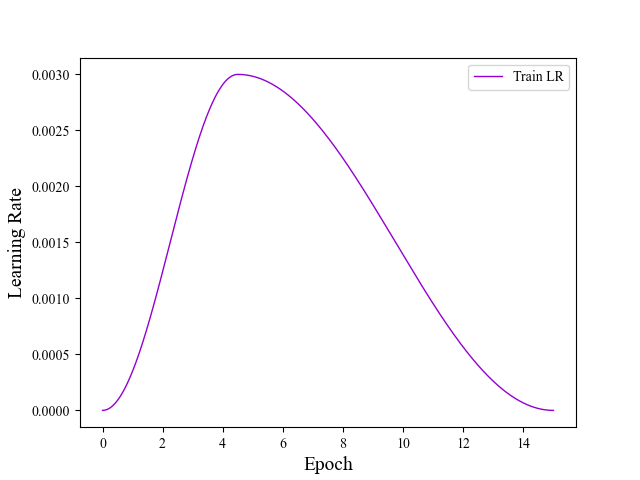

In [11]:
class OneCycleLR:
    def __init__(self, optim, max_lr, epochs, steps_per_epoch=1, pct_start=0.3):
        super(OneCycleLR, self).__init__()
        self.step_num = 0
        self.optim = optim
        self.total_steps = epochs * steps_per_epoch
        self.step_size_up = float(pct_start * self.total_steps) - 1
        self.step_size_down = float(self.total_steps - self.step_size_up) - 1
        self.learning_rate = max_lr
        self.step()

    # 学习率的余弦退火函数
    @staticmethod
    def _annealing_cos(start, end, pct):
        cos_out = math.cos(math.pi * pct) + 1
        return end + (start - end) / 2.0 * cos_out

    # 根据设置的学习率上升与下降段的比例调整学习率
    def step(self):
        down_step_num = self.step_num - self.step_size_up
        a = self._annealing_cos(self.learning_rate * 0.00001, self.learning_rate, self.step_num / self.step_size_up)
        b = self._annealing_cos(self.learning_rate, self.learning_rate * 0.00001, down_step_num / self.step_size_down)
        if self.step_num < self.step_size_up:
            lr_value = a
        else:
            lr_value = b
        self.optim.lr = lr_value
        self.step_num += 1

## 4.网络模型
模型的主体部分，通过上一小节中的手写模块实现了LeNet、ResNet9、ResNet18和ResNet50 & WRN50_2的网络架构。

### 4.1 LeNet
LeNet是最早的神经网络之一，包括C1卷积层、S2池化层（下采样）、C3卷积层、S4池化层、两个全连接层和输出全连接层。

In [12]:
class LeNet(BaseModule):
    def __init__(self, config):
        super(LeNet, self).__init__(config)
        self.conv1 = Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        fc1_size = ((32 - 5 + 1) // 2 - 5 + 1) // 2

        self.max_pool = MaxPool2d(kernel_size=(2, 2), stride=2)
        self.activation = ReLU()

        self.fc1 = Linear(in_features=16 * fc1_size * fc1_size, out_features=120)
        self.fc2 = Linear(in_features=120, out_features=84)
        self.fc3 = Linear(in_features=84, out_features=config.class_num)

        self.loss = CrossEntropyLoss()
        self.optimizer = SGD(
            params=self.parameters(),
            lr=config.lr,
            momentum=config.momentum
        )

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv1_out = self.activation(conv1_out)
        max_pool1_out = self.max_pool(conv1_out)
        conv2_out = self.conv2(max_pool1_out)
        conv2_out = self.activation(conv2_out)
        max_pool2_out = self.max_pool(conv2_out)
        max_pool2_out = max_pool2_out.view(x.size()[0], -1)
        fc1_out = self.fc1(max_pool2_out)
        fc1_out = self.activation(fc1_out)
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.activation(fc2_out)
        fc3_out = self.fc3(fc2_out)
        return fc3_out

### 4.2 ResNet9
构造9层的ResNet，参照[github](https://github.com/davidcpage/cifar10-fast)：
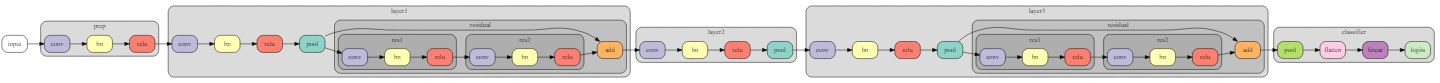

In [13]:
class ResNet9Block(Sequential):
    def __init__(self, in_channels, out_channels, max_pooling=True):
        layers = [
            Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            BatchNorm2d(num_features=out_channels),
            ReLU()
        ]
        if max_pooling is True:
            layers.append(MaxPool2d(kernel_size=(2, 2), stride=2))
        super(ResNet9Block, self).__init__(*layers)

        
class ResNet9(BaseModule):
    def __init__(self, config):
        super(ResNet9, self).__init__(config)
        self.conv1 = ResNet9Block(in_channels=3, out_channels=32, max_pooling=False)
        self.conv2 = ResNet9Block(in_channels=32, out_channels=64, max_pooling=True)
        self.res1 = Sequential(
            ResNet9Block(in_channels=64, out_channels=64, max_pooling=False),
            ResNet9Block(in_channels=64, out_channels=64, max_pooling=False)
        )
        self.conv3 = ResNet9Block(in_channels=64, out_channels=128, max_pooling=False)
        self.conv4 = ResNet9Block(in_channels=128, out_channels=256, max_pooling=True)
        self.res2 = Sequential(
            ResNet9Block(in_channels=256, out_channels=256, max_pooling=False),
            ResNet9Block(in_channels=256, out_channels=256, max_pooling=False)
        )
        self.conv5 = ResNet9Block(in_channels=256, out_channels=512, max_pooling=False)
        self.conv6 = ResNet9Block(in_channels=512, out_channels=1024, max_pooling=True)
        self.res3 = Sequential(
            ResNet9Block(in_channels=1024, out_channels=1024, max_pooling=False),
            ResNet9Block(in_channels=1024, out_channels=1024, max_pooling=False)
        )
        self.fc = Sequential(
            MaxPool2d(kernel_size=(4, 4), stride=4),
            Flatten(),
            Dropout(dropout_ratio=config.dropout),
            Linear(in_features=config.conv6_channels, out_features=config.class_num)
        )

        self.loss = CrossEntropyLoss()
        self.optimizer = SGD(
            params=self.parameters(),
            lr=config.lr,
            weight_decay=config.weight_decay
        )
        self.scheduler = OneCycleLR(
            optim=self.optimizer,
            max_lr=config.lr,
            epochs=config.epoch_num,
            steps_per_epoch=config.train_batch_num
        )

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        res1_out = self.res1(conv2_out) + conv2_out
        conv3_out = self.conv3(res1_out)
        conv4_out = self.conv4(conv3_out)
        res2_out = self.res2(conv4_out) + conv4_out
        conv5_out = self.conv5(res2_out)
        conv6_out = self.conv6(conv5_out)
        res3_out = self.res3(conv6_out) + conv6_out
        scores = self.fc(res3_out)
        return scores

### 4.3 常规ResNet的基本模块
实现了ResNet的基本模块——残差块，供后续叠加使用。

In [14]:
class BasicBlock(BaseModule):
    def __init__(self, in_channels, downsample=False):
        super(BasicBlock, self).__init__()

        if downsample is True:
            out_channels = 2 * in_channels
        else:
            out_channels = in_channels

        self.conv1 = Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = BatchNorm2d(num_features=out_channels)
        self.conv2 = Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(num_features=out_channels)
        if downsample is True:
            self.downsample = Sequential(
                Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False),
                BatchNorm2d(num_features=out_channels)
            )
        else:
            self.downsample = None
        self.relu = ReLU()

    def __call__(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(BaseModule):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False, width=1):
        super(Bottleneck, self).__init__()
        bottleneck_channels = width * out_channels // 4
        self.conv1 = Conv2d(in_channels=in_channels, out_channels=bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(num_features=bottleneck_channels)
        self.conv2 = Conv2d(in_channels=bottleneck_channels, out_channels=bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = BatchNorm2d(num_features=bottleneck_channels)
        self.conv3 = Conv2d(in_channels=bottleneck_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.bn3 = BatchNorm2d(num_features=out_channels)
        self.relu = ReLU()
        if downsample is True:
            self.downsample = Sequential(
                Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_features=out_channels)
            )
        else:
            self.downsample = None
        self.stride = stride

    def __call__(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetLayer(Sequential):
    def __init__(self, in_channels, blocks, stride=None, out_channels=None, fisrt_layer_downsample=True, width=1):
        if out_channels is None:
            layers = [BasicBlock(in_channels=in_channels, downsample=fisrt_layer_downsample)]
            for _ in range(1, blocks):
                layers.append(BasicBlock(in_channels=in_channels if not fisrt_layer_downsample else in_channels * 2))
        else:
            layers = [Bottleneck(in_channels=in_channels, out_channels=out_channels, stride=stride, downsample=True, width=width)]
            for _ in range(1, blocks):
                layers.append(Bottleneck(in_channels=out_channels, out_channels=out_channels, width=width))
        super(ResNetLayer, self).__init__(*layers)

### 4.4 ResNet18
18层的ResNet，由17个卷积层（conv）和1个全连接层（fc）构成。

In [15]:
class ResNet18(BaseModule):
    def __init__(self, config):
        super(ResNet18, self).__init__(config)
        self.conv1 = Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = BatchNorm2d(num_features=64)
        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResNetLayer(in_channels=64, blocks=2, fisrt_layer_downsample=False)
        self.layer2 = ResNetLayer(in_channels=64, blocks=2)
        self.layer3 = ResNetLayer(in_channels=128, blocks=2)
        self.layer4 = ResNetLayer(in_channels=256, blocks=2)
        self.avgpool = AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = Flatten()
        self.fc = Sequential(
            Linear(in_features=512, out_features=128),
            ReLU(),
            Linear(in_features=128, out_features=10)
        )

        self.loss = CrossEntropyLoss()
        self.optimizer = SGD(
            params=self.parameters(),
            lr=config.lr,
            momentum=config.momentum
        )
        self.scheduler = OneCycleLR(
            optim=self.optimizer,
            max_lr=config.lr,
            epochs=config.epoch_num,
            steps_per_epoch=config.train_batch_num
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

### 4.5 ResNet50 & WRN50_2
该模块可被ResNet50、WRN50_2所通用，使用时只需调整`config`类，通过width属性控制bottleneck的通道数。

In [16]:
class ResNet50(BaseModule):
    def __init__(self, config):
        super(ResNet50, self).__init__(config)
        self.conv1 = Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = BatchNorm2d(num_features=64)
        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResNetLayer(in_channels=64, out_channels=256, blocks=3, stride=1, width=config.width)
        self.layer2 = ResNetLayer(in_channels=256, out_channels=512, blocks=4, stride=2, width=config.width)
        self.layer3 = ResNetLayer(in_channels=512, out_channels=1024, blocks=6, stride=2, width=config.width)
        self.layer4 = ResNetLayer(in_channels=1024, out_channels=2048, blocks=3, stride=2, width=config.width)
        self.avgpool = AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = Flatten()
        self.fc = Sequential(
            Linear(in_features=2048, out_features=512),
            ReLU(),
            Linear(in_features=512, out_features=128),
            ReLU(),
            Linear(in_features=128, out_features=10)
        )
        self.loss = CrossEntropyLoss()
        self.optimizer = SGD(
            params=self.parameters(),
            lr=config.lr,
            momentum=config.momentum,
            weight_decay=config.weight_decay
        )
        self.scheduler = OneCycleLR(
            optim=self.optimizer,
            max_lr=config.lr,
            epochs=config.epoch_num,
            steps_per_epoch=config.train_batch_num
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

## 5.神经网络训练工具类：Trainer
集成了模型训练、测试、模型存储、训练日志存储、训练过程的准确率和损失值可视化等功能。

In [17]:
class Trainer:
    def __init__(self, config, network, datamanager):
        # 用时信息
        self.start_time = config.start_time   # 获取程序开始时间
        self.end_time = None                  # 定义程序结束时间

        # 保存传入参数
        self.config = config                  # 获取配置类实例的入口
        self.network = network                # 获取神经网络实例的入口
        self.datamanager = datamanager        # 获取数据预处理类实例的入口

        # 训练过程中需要记录的信息
        self.best_model = None                # 暂存最优模型参数
        self.best_acc = 0.0                   # 记录最高准确率
        self.training_log = []                # 日志文件信息列表
        self.train_acc = []                   # 训练全程训练集准确率列表
        self.test_acc = []                    # 训练全程测试集准确率列表
        self.loss = []                        # 训练全程损失函数值列表

    # 训练函数，包含训练集、测试集上准确率的计算
    def train(self):
        self.network.train()            # 将神经网络设置为训练状态
        print('Epoc\tTrain\tTest\tLoss')
        
        dataloader = self.datamanager.get_train_dataloader()
        for i in range(self.config.epoch_num):
            loss = 0
            start = time.time()
            for j, data in enumerate(dataloader):
                data[0] = data[0].to(self.config.device)
                data[1] = data[1].to(self.config.device)
                loss += self.network.step(data)
                end = time.time()
                info = '\rEpoch ' + str(i + 1) + ' completed: ' + str(
                    round(j * 100 / len(dataloader))) + ' % ' + str(round(end - start, 2)) + 's'
                print(info, end='')      # 打印进度信息
            loss /= len(dataloader)      # 计算每个batch上的平均损失值
            self.loss.append(loss)
            acc_info = '{:<8d}'.format(i + 1)
            train_acc = self.test(mode='Train')        # 计算训练集准确率
            acc_info = acc_info + '{:<8.1f}'.format(train_acc * 100)
            test_acc = self.test(mode='Test')          # 计算测试集准确率
            acc_info = acc_info + '{:<8.1f}'.format(test_acc * 100)
            acc_info = acc_info + '{:<8.4f}'.format(loss)
            print('\r' + acc_info + '                                          ')   # 打印一个epoch上的准确率和损失值信息

        self.end_time = time.time()
        print('==================================================')
        print('Time consumed:', round(self.end_time - self.start_time, 1), 's')     # 打印全程用时

    # 测试函数，包括Train和Test两种模式，分别计算训练集和测试集的准确率
    def test(self, mode='Train'):
        self.network.eval()              # 将神经网络设置为测试状态
        if mode == 'Train':              # 获取对应模式的DataLoader
            dataloader = self.datamanager.get_train_dataloader()
        else:
            dataloader = self.datamanager.get_test_dataloader()

        correct_num = 0
        overall_num = 0
        length = len(dataloader)
        for i, data in enumerate(dataloader):
            data[0] = data[0].to(self.config.device)
            data[1] = data[1].to(self.config.device)
            c, o = self.network.evaluate(data)
            correct_num += c
            overall_num += o
            if mode == 'Train':
                info = 'Calculating accuracy on training set: ' + str(round(100 * i / length)) + ' %'
            else:
                info = 'Calculating accuracy on testing set:' + str(round(100 * i / length)) + ' %'
            print('\r' + info + '        ', end='')      # 打印进度信息
        acc = correct_num / overall_num

        if mode == 'Train':              # 记录准确率并保存最优模型
            self.train_acc.append(acc)
        else:
            self.test_acc.append(acc)
            if acc > self.best_acc:
                self.best_acc = acc
                if self.best_model is not None:
                    del self.best_model
                self.best_model = copy.deepcopy(self.network.state_dict())
        self.network.train()             # 将神经网络设置为训练状态
        return acc

    # 保存在测试集上准确率最高的模型
    def save_model(self):
        model = self.network.__class__.__name__
        t = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = model + '_' + t + '.pt'
        path = './Model/' + filename
        torch.save(self.best_model, path)

    # 保存训练日志
    def save_training_log(self):
        model = self.network.__class__.__name__
        t = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = model + '_' + t + '.txt'
        path = './TrainingLog/' + filename
        file = open(path, 'w')
        training_info = self.config.get_training_info()
        for info in training_info:
            file.write(info + '\n')
        file.write('==============================\n')
        file.write('Epoc    Train   Test    Loss    \n')
        for i in range(self.config.epoch_num):
            line = '{:<8d}'.format(i + 1) + '{:<8.1f}'.format(self.train_acc[i] * 100) + \
                   '{:<8.1f}'.format(self.test_acc[i] * 100) + '{:<8.4f}'.format(self.loss[i]) + '\n'
            file.write(line)
        file.write('==============================\n')
        line = 'Best acc: ' + str(round(self.best_acc * 100, 1)) + '%\n'
        file.write(line)
        line = 'Time consumed: ' + str(round(self.end_time - self.start_time, 1)) + 's\n'
        file.write(line)
        file.close()

    # 显示并保存准确率和损失值变化曲线
    def visualize(self):
        model = self.network.__class__.__name__
        t = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        acc_filename = model + '_' + t + 'acc.jpg'
        loss_filename = model + '_' + t + 'loss.jpg'
        acc_path = './Figure/' + acc_filename
        loss_path = './Figure/' + loss_filename

        x = np.array(range(1, self.config.epoch_num + 1))
        y1 = np.array(self.train_acc)
        y1 = y1 * 100
        y2 = np.array(self.test_acc)
        y2 = y2 * 100
        y3 = np.array(self.loss)

        plt.figure()
        plt.xlabel('Epoch', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.ylabel('Accuracy/%', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.plot(x, y1, 'dodgerblue', linewidth=1.0, label='Train')
        plt.plot(x, y2, 'red', linewidth=1.0, label='Test')
        plt.xticks(fontproperties='Times New Roman', size=10)
        plt.yticks(fontproperties='Times New Roman', size=10)
        plt.legend(prop={'family': 'Times New Roman', 'size': 10})
        plt.savefig(acc_path)
        plt.show()

        plt.figure()
        plt.xlabel('Epoch', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.ylabel('Loss', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.plot(x, y3, 'darkviolet', linewidth=1.0, label='Train')
        plt.xticks(fontproperties='Times New Roman', size=10)
        plt.yticks(fontproperties='Times New Roman', size=10)
        plt.legend(prop={'family': 'Times New Roman', 'size': 10})
        plt.savefig(loss_path)
        plt.show()

## 6.模型训练

Files already downloaded and verified
Files already downloaded and verified
Epoc	Train	Test	Loss
1       33.1    33.4    2.2915                                            
2       93.6    92.5    1.1782                                            
3       98.0    95.8    0.1744                                            
4       98.5    96.0    0.0998                                            
5       99.0    96.2    0.0710                                            
6       99.6    96.8    0.0436                                            
7       99.8    97.2    0.0269                                            
8       99.8    97.2    0.0190                                            
9       100.0   97.4    0.0112                                            
10      100.0   97.6    0.0055                                            
11      100.0   97.8    0.0030                                            
12      100.0   97.7    0.0024                                            
13 

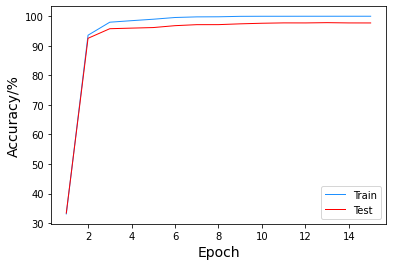

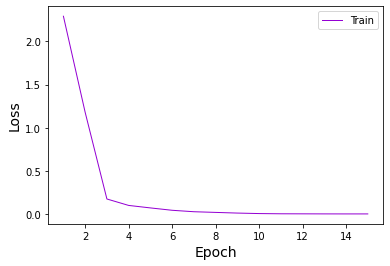

In [18]:
config = Config(name='WRN50_2', mode='Train')
datamanager = DataManager(config)
network = config.get_network()
trainer = Trainer(config, network, datamanager)
trainer.train()
trainer.save_model()
trainer.save_training_log()
trainer.visualize()